In [1]:
import os
import pandas as pd
import copy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from transformers import BertTokenizerFast
import shap
import scipy as sp
import nlp
import torch
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)
pd.set_option("max_rows", None)
from datasets import load_dataset
import spacy
import seaborn as sns
import time

In [2]:
from pytorch_transformers import (WEIGHTS_NAME, BertConfig,
                                  BertForSequenceClassification)

from pytorch_transformers import AdamW, WarmupLinearSchedule 

In [3]:
MODEL_CLASSES = {
    'bert': (BertConfig, BertForSequenceClassification, BertTokenizerFast)
}
config_class, model_class, tokenizer_class = MODEL_CLASSES['bert']

In [4]:
def get_labels_from_label_dict(lbl_dict_path):
        line_id = 0
        labels = []
        for line in open(lbl_dict_path, encoding='utf8'):
            fds = line.strip().split(' ')
            assert len(fds) == 2, 'incorrect format {}'.format(line)
            lbl = fds[0]
            fid = int(fds[1])
            assert fid == line_id, 'id not correct {} -- {}'.format(fid, line_id)
            labels.append(lbl)
            line_id += 1
        return labels

In [5]:
args = {
'data_dir':'C:\\Users\\ryserrao\\Microsoft_work\\AIPLATFORM_SHAP\\PPT_Text_to_Icon_Data\\Turing_Text2Icon_Code_and_Model\\outputs',
'model_name_or_path':'ft_set12_256x2_pcln2sc_nowiki.py_e10_wu02_bs8_ts08_sc12_lr7e-5',
'data_path':'test_mturk.txt',
'task_name':'text2content',
'do_lower_case':True,
'lbl_dict_path' : 'train.txt.lbl.dict.txt',
'max_seq_len':32
}
labels = get_labels_from_label_dict(os.path.join(args['data_dir'], args['lbl_dict_path']))
num_labels = len(labels)

In [6]:
config = config_class.from_pretrained(os.path.join(args['data_dir'],args['model_name_or_path']), num_labels=num_labels, finetuning_task=args['task_name'])
tokenizer = tokenizer_class.from_pretrained(os.path.join(args['data_dir'],args['model_name_or_path']), do_lower_case=args['do_lower_case'])
model = model_class.from_pretrained(os.path.join(args['data_dir'],args['model_name_or_path']),config=config).cuda()

{
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": "text2content",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "initializer_range": 0.02,
  "intermediate_size": 1024,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 8,
  "num_hidden_layers": 2,
  "num_labels": 865,
  "output_attentions": false,
  "output_hidden_states": false,
  "pooler": "cls",
  "torchscript": false,
  "type_vocab_size": 2,
  "vocab_size": 30522
}



In [7]:
label2id = {}
id2label = {}
for i,label in enumerate(labels):
    label2id[label]=i
    id2label[i]=label

In [8]:
data = nlp.load_dataset('reddit',split='train')

WARNING - Using custom data configuration default


In [9]:
data

Dataset(features: {'author': Value(dtype='string', id=None), 'body': Value(dtype='string', id=None), 'normalizedBody': Value(dtype='string', id=None), 'subreddit': Value(dtype='string', id=None), 'subreddit_id': Value(dtype='string', id=None), 'id': Value(dtype='string', id=None), 'content': Value(dtype='string', id=None), 'summary': Value(dtype='string', id=None)}, num_rows: 3848330)

In [10]:
subreddit = data['subreddit']

#### Unique subreddits

In [11]:
print(f'Total unique subreddits: {len(set(subreddit))}')


Total unique subreddits: 29651


In [12]:
print(list(set(subreddit))[:1000])

['', 'PizzaPresser', 'gunmeetups', 'FloridaMan', 'AskPhilly', 'DatingHell', 'Runner5', 'investing_discussion', 'FoxCoin', 'learnruby', 'chicagobulls', 'GlobalPowers', 'controllablewebcams', 'ClosetSanta', 'Krishnamurti', 'mylittlealcoholic', 'fbla', 'MICF2015', 'shitpostemblem', 'bearbros', 'pokemongoNYC', 'ImmortalKingsMC', 'incest_relationships', 'FCPrimal', 'CTD', 'InboxInvites', 'stanford', 'TransSpace', 'StaffCraft', 'portugaltheman', 'Sissies', 'MilitaryPorn', 'totalanguage', 'Deskbots', 'BreakfastatPiffanyz', 'canadasmallbusiness', 'lonelyrunners', 'Ringling', 'vapebonging', 'wetshaving101', 'Alienware', 'restorethefourthMN', 'DragonHeroes', 'small_business_ideas', 'LiveFromNewYork', 'asm', 'ImGoingToHellForThis', 'waterford', 'FCInterMilan', 'Vaping101', 'skinwalkers', 'SOS', 'ketorage', 'eastborobaptistchurch', 'MLPCCardGame', 'TributeMe', 'dogecoindev', 'opendirectories', 'Disneycollegeprogram', 'Charity', 'libertariancomics', 'gettingsexyback', 'Xanzia', 'IndonesianGamers', 

In [17]:
def f(x):
    tv = torch.tensor([tokenizer.encode(v, pad_to_max_length=True, max_length=args['max_seq_len'],truncation=True) for v in x]).cuda()
    attention_mask = (tv!=0).type(torch.int64).cuda()
    outputs = model(tv,attention_mask=attention_mask)[0].detach().cpu().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores) 
    return val

In [18]:
explainer = shap.Explainer(f,tokenizer,output_names=labels)

explainers.Partition is still in an alpha state, so use with caution...


#### Semantic grouping of words

In [9]:
import heapq as pq
nlp = spacy.load("en_vectors_web_lg")

In [10]:
def semantic_grouping(semantic_groups_ll,sentences,topk=10):
    for group in semantic_groups_ll:
        semantic_groups_dict[group]={'similar_words':[],'unique_words':set(),'token_spacy':nlp(group)}
    for i,sentence in enumerate(sentences):
        #print(i,sentence)
        tokens = nlp(sentence)
        for token in tokens:
            for group in semantic_groups_ll:
                if token.text not in semantic_groups_dict[group]['unique_words']:
                    if len(semantic_groups_dict[group]['unique_words'])<topk:
                        pq.heappush(semantic_groups_dict[group]['similar_words'],(semantic_groups_dict[group]['token_spacy'].similarity(token),token.text))
                        semantic_groups_dict[group]['unique_words'].add(token.text)
                    else:
                        sim_score, text = pq.heappop(semantic_groups_dict[group]['similar_words'])
                        semantic_groups_dict[group]['unique_words'].remove(text)
                        new_sim_score = semantic_groups_dict[group]['token_spacy'].similarity(token)
                        if new_sim_score>sim_score:
                            pq.heappush(semantic_groups_dict[group]['similar_words'],(new_sim_score,token.text))
                            semantic_groups_dict[group]['unique_words'].add(token.text)
                        else:
                            pq.heappush(semantic_groups_dict[group]['similar_words'],(sim_score,text))
                            semantic_groups_dict[group]['unique_words'].add(text)

In [24]:
def extract_similar_words(group):
    sem_group = []
    for _, g in sorted(semantic_groups_dict[group]['similar_words'],reverse=True):
        sem_group.append(g)
    return sem_group

#### Find subreddits similar to gender, male, female

In [67]:
semantic_groups_ll = ['slang']
semantic_groups_dict={}
semantic_grouping(semantic_groups_ll, list(set(data['subreddit'])), topk=50)

[W008] Evaluating Doc.similarity based on empty vectors.
[W008] Evaluating Doc.similarity based on empty vectors.


In [68]:
for group in semantic_groups_ll:
    print(f'Semantic group: {group}')
    print(f'Words: {",".join(extract_similar_words(group))} \n')

Semantic group: slang
Words: dictionary,etymology,vocabulary,Jokes,puns,language,grammar,rap,gibberish,wordplay,Spanish,ENGLISH,latin,queer,shit,linguistics,dutch,words,Yiddish,languages,wikipedia,dumbass,etiquette,humor,insults,geek,plural,Vietnamese,punk,Cantonese,Portuguese,Names,Hipster,Tagalog,French,nazi,mumble,australian,illiterate,Irony,origins,Graffiti,Hookers,culture,clue,funny,Weird,bitch,translator,German 



#### Filter sentences to subreddits

In [54]:
def extract_subreddit_sentences(subreddits,k=0,kmax=1000,step=100):
    filtered_df=None
    while k<kmax:
        print(f'Accessing data from index {k} to {k+step}')
        new_df = pd.DataFrame({'subreddit': data['subreddit'][k:k+step], 'summary': data['summary'][k:k+step]})
        new_df=new_df[new_df['subreddit'].isin(subreddits)]
        if filtered_df is None:
            filtered_df = new_df
        else:
            filtered_df = pd.concat([filtered_df,new_df])
        del new_df
        k+=step
    return filtered_df

In [61]:
df = extract_subreddit_sentences(["gender","men","women","sex","AskReddit"],0,3000000,500000)

Accessing data from index 0 to 500000
Accessing data from index 500000 to 1000000
Accessing data from index 1000000 to 1500000
Accessing data from index 1500000 to 2000000
Accessing data from index 2000000 to 2500000
Accessing data from index 2500000 to 3000000


In [63]:
df.shape

(598847, 2)

In [66]:
df[df['subreddit']=="men"][:100]

,subreddit,summary
350258,men,"Don't be surprised if it is temporary, and be willing to branch out and notice the lovely women where you are currently. She's NOT the only lovely competitive spitfire on the planet. Time to break your shell, there's a bigger world."
370490,men,you're normal.
378734,men,No.
184184,men,"Be yourself, and don't care what others think."
184185,men,"they help you realize you can do it easily, but provide little ""new"" knowledge."
317250,men,"I am having more trouble dealing with mental images that I get when thinking about it, things trigger those thoughts often too. Maybe I'm just crazy."
99894,men,colored briefs
259962,men,The chick reacted the way I imagine anyone would react if they were propositioned by a friend who then got indignant for not being let into their pants.
196823,men,"The important thing is not being a ""man"" or demonstrating that you are one. The important thing is that you feel like one . Period. Cut yourself some slack, you can't win all the time and most importantly, this situation of letting the smug guy walk away does not define you as a male in any way possible ."
395275,men,"If you really want to turn men into feminists, treat their issues with the same respect you would want yours treated with, talk about all sides of an issue, not just the parts you like, don't demonize them as oppressors, and really, you should form the thesis of your argument based on the data, not vice-versa."


#### Identifying words related to gender

In [ ]:
gender = ["feminine", "Ladies"]

#### Find words in corpus which relate to gender

In [22]:
semantic_groups_ll = ['gender','male','female']
semantic_groups_dict={}
semantic_grouping(semantic_groups_ll, df_politics['summary'], topk=50)

[W008] Evaluating Doc.similarity based on empty vectors.
[W008] Evaluating Doc.similarity based on empty vectors.


In [36]:
for group in politics_group:
    print(f'Semantic group: {group}')
    print(f'Words: {",".join(extract_similar_words(group))} \n')

Semantic group: Republicans
Words: Republicans,republicans,REPUBLICANS,democrats,Democrats,republican,Republican,dems,Dems,conservatives,Conservatives,liberals,Liberals,democrat,Democrat,GOP,Progressives,McCain,obama,Obama,Romney,politicians,Politicians,racists,Senate,libertarians,Libertarians,conservative,Conservative,liberal,Liberal,morons,congress,Congress,Americans,idiots,Idiots,independents,Independents,Palin,bigots,Bigots,voters,evangelicals,Christians,politics,Politics,Clinton,CLINTON,election 

Semantic group: China
Words: China,Taiwan,usa,USA,Europe,Germany,america,America,AMERICA,Canada,Australia,Russia,UK,England,Arabia,american,American,iran,Iran,Britain,Christmas,Saudi,canadian,Canadian,Chicago,York,Switzerland,United,Israel,Asian,Finland,suppliers,Tea,co,cheap,Afghanistan,Paris,African,glass,Cuba,english,English,Disney,Italian,U.S.,manufacturers,Norway,Buddhism,German,Iphone 

Semantic group: US
Words: US,us,Us,we,We,WE,our,Our,them,me,Me,give,Give,let,Let,everyone,Everyo

#### Cumulative shap

In [53]:
def get_cumulative_shap_values_abs_mean(word_set,shap_values):
    token_list = shap_values.mean(0).feature_names.tolist()
    token_set = set(token_list)
    shap_values_abs_mean = shap_values.abs.mean(0)
    shap_values_list = []
    for word in word_set:
        if word in token_set:
            shap_values_word = shap_values_abs_mean.values[token_list.index(word)]
            shap_values_list.append(shap_values_word)
    
    if shap_values_list:
        return np.array(shap_values_list).mean(0)
    else:
        return np.zeros(shap_values.base_values[0].shape)

#### Top icons affected by a semantic group

In [98]:
def plot_top_icons_for_semantic_group(group,shap_values,topk=10):
    if isinstance(group,str):
        risk = get_cumulative_shap_values_abs_mean(extract_similar_words(group),shap_values)
    else:
        risk = get_cumulative_shap_values_abs_mean(group,shap_values)
    df = pd.DataFrame({'Icons':labels,'Risk':risk})
    topk_df=df.sort_values(by = 'Risk', ascending = False)[:topk]
    ax = sns.barplot(x="Risk", y="Icons", data=topk_df,color="royalblue")
    ax.set_title(f'Top icons affected by semantic group: {group}')
    plt.show()

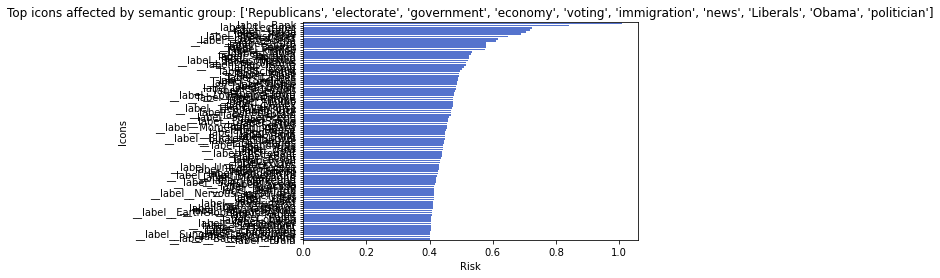

In [99]:
#for group in politics_group:
plot_top_icons_for_semantic_group(politics_group,shap_values_politics,topk=100)

In [90]:
def extract_sentences(icon,group,shap_values,topk=10):
    if isinstance(group,str):
        semantic_group=extract_similar_words(group)
    else:
        semantic_group=group
    semantic_group_set = set(semantic_group)
    shortlist_sentences=[]
    for sent_index,sentence in enumerate(shap_values.data):
        shap_sentence_score=[]
        shap_words=[]
        for word_index,word in enumerate(sentence):
            if word in semantic_group_set:
                shap_score = shap_values[sent_index].values[word_index][label2id[icon]]
                if shap_score>0:
                    shap_sentence_score.append(shap_score)
                    shap_words.append(word)
        if shap_sentence_score:
            cumulative_shap_effect = np.mean(shap_sentence_score)
            sentence = ' '.join(sentence)
            for w in shap_words:
                sentence = sentence.replace(w,"\033[1m"+w+"\033[0m")
            shortlist_sentences.append((cumulative_shap_effect,sentence,sent_index))
    sorted_shortlist_sentences = []
    for _, s,sent_index in sorted(shortlist_sentences,reverse=True):
        sorted_shortlist_sentences.append((s,sent_index))
    return sorted_shortlist_sentences[:10]

In [96]:
shortlist_sentences = extract_sentences('__label__Nose',politics_group,shap_values_politics)

In [97]:
for i,sentence in enumerate(shortlist_sentences):
    print(f'\n \033[1m Sentence {i+1}: \033[0m')
    print(sentence[0])


  Sentence 1: 
 Take  into  account  a  few  fair  assumptions  about  Mel ale e ' s  age ,  education ,  and  geographical  location ,  and  it ' s  perfectly  understand able  that  they  would  hold  an  inaccurate  app rai sal  of  Obama ' s  current  quality  as  a  President . 


In [110]:
def f_label(x):
    x=["Take  into  account  a  few  fair  assumptions  about  Mel ale e ' s  age ,  education ,  and  geographical  location"]
    tv = torch.tensor([tokenizer.encode(v, pad_to_max_length=True, max_length=args['max_seq_len'],truncation=True) for v in x]).cuda()
    attention_mask = (tv!=0).type(torch.int64).cuda()
    outputs = model(tv,attention_mask=attention_mask)[0].detach().cpu().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    return id2label[np.argmax(scores[0])]

In [112]:
f_label(["Take  into  account  a  few  fair  assumptions  about  Mel ale e ' s  age ,  education ,  and  geographical  location ,  and  it ' s  perfectly  understand able  that  they  would  hold  an  inaccurate  app rai sal  of  Obama ' s  current  quality  as  a  President ."])

'__label__Marker'

#### Text and Bar plots

In [ ]:
def custom_masked_bar_plot(class_index,mask_type,viz_type):
    #determine type of operation on the explanation object
    if viz_type=='mean':
        compute_shap=copy.copy(shap_values_multiclass.mean(0))
    if viz_type=='sum':
        compute_shap=copy.copy(shap_values_multiclass.sum(0))
    if viz_type=='abs_mean':
        compute_shap=copy.copy(shap_values_multiclass.abs.sum(0))
    if viz_type=='abs_sum':
        compute_shap=copy.copy(shap_values_multiclass.abs.sum(0))
    #create a mask to visualize either positively or negatively contributing features
    if mask_type=='pos':
        mask=compute_shap.values[:,class_index]>=0
    else:
        mask=compute_shap.values[:,class_index]<=0
    #slice values related to a given class
    compute_shap.values=compute_shap.values[:,class_index][mask]
    compute_shap.feature_names=list(np.array(compute_shap.feature_names)[mask])
    #plot
    shap.plots.bar(compute_shap.abs,order=shap.Explanation.identity)

In [119]:
def text_plot(class_index,start_idx,end_idx,shap_values_temp):
    shap_values = copy.copy(shap_values_temp[:])
    #slice values related to a given class
    if len(shap_values.base_values.shape) == 1:
        shap_values.values = shap_values.values[:,class_index]
        shap_values.hierarchical_values = shap_values.hierarchical_values[:,class_index]
        shap_values.base_values = shap_values.base_values[class_index]
    else:
        for i in range(start_idx,end_idx):
            shap_values.values[i] = shap_values.values[i][:,class_index]
            shap_values.hierarchical_values[i] = shap_values.hierarchical_values[i][:,class_index]
        shap_values.base_values = shap_values.base_values[:,class_index]
    #plot
    shap.plots.text(shap_values[start_idx:end_idx])

In [ ]:
label='__label__Fire'
custom_masked_bar_plot(label2id[label],'pos','mean')

In [121]:
text_plot(label2id['__label__Nose'],0,1,shap_values_politics)

AttributeError: 'numpy.ndarray' object has no attribute 'replace'